In [1]:
import geopandas as gpd
import pandas as pd
import routingpy as rp
import numpy as np
import time
from matplotlib import pyplot as plt
import h3
import warnings
warnings.filterwarnings("ignore")  # Silence some warnings

https://routingpy.readthedocs.io/en/latest/#valhalla

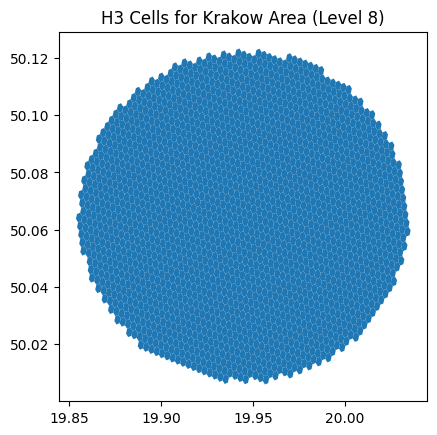

In [1]:
import geopandas as gpd
import h3
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

# Define Krakow's coordinates and buffer
krakow_coords = (19.9449799, 50.0646501)  # Coordinates of Krakow center
buffer_radius = 10000  # 50 km buffer

# Create a GeoDataFrame for Krakow's buffer
crs = 'epsg:4326'
krakow_point = gpd.GeoDataFrame(geometry=[Point(krakow_coords)], crs=crs)
krakow_buffer = krakow_point.to_crs('epsg:3857').buffer(buffer_radius).to_crs(crs)

# Generate H3 cells for level 8 within the buffer
h3_resolution = 9
krakow_bounds = krakow_buffer.geometry[0].bounds  # Get bounds of the buffered region
min_lat, min_lon, max_lat, max_lon = krakow_bounds
h3_cells = h3.polyfill(krakow_buffer.geometry[0].__geo_interface__, h3_resolution)

# Create GeoDataFrame for H3 cells
h3_geoms = [Polygon(h3.h3_to_geo_boundary(h)) for h in h3_cells]
gdf_h3_krk = gpd.GeoDataFrame({'h3_index': list(h3_cells)}, geometry=h3_geoms, crs=crs)

# Plot the generated H3 cells
gdf_h3_krk.plot()
plt.title("H3 Cells for Krakow Area (Level 8)")
plt.show()

In [13]:
# settipng up service
api = rp.Valhalla(base_url= 'https://valhalla1.openstreetmap.de')

In [14]:
gdf_h3_krk = gdf_h3_krk.to_crs('epsg:4326')
gdf_h3_krk['x'] = gdf_h3_krk['geometry'].centroid.apply(lambda p: p.x)
gdf_h3_krk['y'] = gdf_h3_krk['geometry'].centroid.apply(lambda p: p.y)

In [ ]:
new_df = pd.DataFrame()
counter=0

for index, row in gdf_h3_krk.iterrows():
    try:
        counter+=1
        h3_cell = h3.geo_to_h3(row.y, row.x, h3_resolution)
        neighbors = h3.k_ring(h3_cell, 1)
        list_nejb_seconds = []

        for cell in neighbors:
            # time.sleep(1)
            lat_lng = h3.h3_to_geo(cell)
            coordinates = [[row.x, row.y], [lat_lng[1], lat_lng[0]]]
            matrix = api.matrix(locations=coordinates, profile='auto')
            time_to = matrix.durations[0][1]
            new_row = pd.DataFrame([{'from': h3_cell, 'to': cell, 'time': time_to}])
            # Concatenate it with the existing DataFrame
            new_df = pd.concat([new_df, new_row], ignore_index=True)
            list_nejb_seconds.append(time_to)

        gdf_h3_krk.loc[index, 'time_mean'] = (np.mean(list_nejb_seconds))
    except:
        print('pass')
        pass

# gdf_h3_krk.to_file(r'd:\GIS\pl\h3_routing\test_head_100.shp')

pass
pass


In [6]:
new_df.to_csv(r'd:\GIS\pl\h3_routing\h3_routing_dict.csv')

<AxesSubplot:>

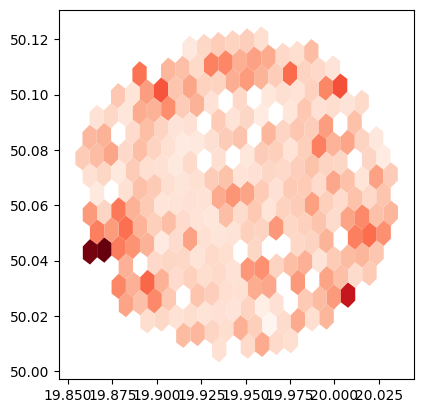

In [10]:
gdf_h3_krk.plot(column='time_mean', cmap='Reds')